# Uncorrelated Inhibition

Here we set the figures for the cases with only excitation in spines.

In [1]:
import numpy as np
from numpy.random import exponential, randint
from numpy import *   #ones, cumsum, sum, isscalar
from matplotlib.pylab import * 
%matplotlib inline
plotose = True

import PS_lib as lb
import PS_storage as st

In [2]:
from bootstrap import *

## Setting up the model

### Topology of the neuron

We set first a simplistic neuron

In [3]:
# Parameter definitions
# Data is stored here      
data = st.dataStorage() # some default parameters defined.
data.dt = 0.05
data.NMDA = False

# Definition of the model.
lb.h.dt = data.dt
NMDA = data.NMDA
model = lb.loadNeuron("Basic2.hoc",axon=False)

# Adding piece of dendritic branch with spine
model.addDend(name="DendE",locus="dendA1",L=4.0,D=1.5,ilocus=1)
model.addSpne(locus="DendE",ilocus=0.5,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)
# Temperature of the neuron
lb.h.celsius = model.temperature
model.addDend(name="DendN",locus=3,L=240.0,D=0.5,ilocus=1)
data.model = model.__dict__

model.soma.L = 20
model.dend[-1].L = 200
model.dend[-1].diam = 10
print(model.soma.L,model.soma.diam,model.soma(0.5).area(),model.dend[-1](0.5).area())

print("Topology:")
print(lb.h.topology())


	0 
	1 
	1 
	1 
	1 
20.0 29.78380012512207 1871.3713533814052 6283.185307179586
Topology:

|-|       soma(0-1)
   `|       dendA1c(0-1)
     `|       dendA1(0-1)
       `|       DendE(0-1)
         `|       DendN(0-1)
        `|       NSpne000(0-1)
          `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0


### Recording places

We set recording vectors in all dendritic compartments, spine included

In [4]:
nsp = 500
dis = btset_cd(cd='DiS',size=nsp)
sis = btset_cd(cd='SiS',size=nsp)
sps = btset_cd(cd='Sp',size=nsp)
iPSDsh = btShInh(size=500)


In [5]:

rhGABAR = 500 # Receptors/um2
rhAMPAR = 1000 # Receptors/um2
rhNMDAR = 10 # Receptors/um2

gtrG = rhGABAR*30e-6*2/5.0
gtrA = rhAMPAR*11e-6*2/5.0
gtrN = rhNMDAR*30e-6/16.0

figureplot=False
if figureplot:
    fig, ax = subplots(nrows=1,ncols=4,figsize=(20,5))
    fig.suptitle("Number of Receptors",fontsize = 20)

    ax[0].hist(sis['A1']*rhAMPAR,31)
    ax[0].set_xlabel("#AMPAR in Sis")
    ax[1].hist(dis['A1']*rhAMPAR,31)
    ax[1].set_xlabel("#AMPAR in Dis")
    ax[2].hist(dis['A2']*rhGABAR,31)
    ax[2].set_xlabel("#GABAAR in Dis")
    ax[3].hist(iPSDsh*rhGABAR,31)
    ax[3].set_xlabel("#GABAAR in shaft")

    fig, ax = subplots(nrows=1,ncols=4,figsize=(20,5))
    fig.suptitle("Max Current",fontsize = 20)


    ax[0].hist(sis['A1']*gtrA/1e-6,31)
    ax[0].set_xlabel("I$_{max}$ (pA)")
    ax[1].hist(dis['A1']*gtrA/1e-6,31)
    ax[1].set_xlabel("I$_{max}$ (pA)")
    ax[2].hist(dis['A2']*gtrG/1e-6,31)
    ax[2].set_xlabel("I$_{max}$ (pA)")
    ax[3].hist(iPSDsh*gtrG/1e-6,31)
    ax[3].set_xlabel("I$_{max}$ (pA)")

### Excitatory synapse 

We need to define the arrival time and dynamics. These parameters may be modified later

In [6]:
model.AMPAlist = []
model.ncAMPAlist = []

AMPA = lb.h.Exp2Syn(1,sec = model.spne[0])
tau1  = 0.5
tau2 = 3.0
AMPA.tau1 = tau1
AMPA.tau2 = tau2

nampa = 50
gmax = 15*nampa/1e6
stimE=lb.h.NetStim();stimE.number = 1; 
NC = lb.h.NetCon(stimE,AMPA,0,0,gmax)

model.AMPAlist.append(AMPA)
model.ncAMPAlist.append(NC)
NC.delay = 10

# NMDA part
nnmda = 2
gmaxN = 50*nnmda/1e6
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA = model.NMDAlist[0]
NCN = model.ncNMDAlist[0]
stimN=lb.h.NetStim();stimN.number = 1;
NCN = lb.h.NetCon(stimN,NMDA,0,0,gmaxN)
model.ncNMDAlist[0] = NCN
NMDA.tau1 = 2.0
NMDA.tau2 = 30.0


### Inhibitory synapse

In [7]:
nGABA = 35
gmaxG = nGABA*30e-6
GABA, NCG = lb.add_GABAsyns(model, locs=[[0,1]], spne=True, gmax=gmaxG,tau1=1.5,tau2=15.0)  


In [8]:
trec, vrec = lb.h.Vector(), lb.h.Vector()
gRec, iRec,  vspneRec = [], [], []
gNMDA_rec, iNMDA_rec = [], []
trec.record(lb.h._ref_t)
vrec.record(model.soma(0.5)._ref_v)


#n=0
vDendRec = []
caDendRec = []
#For all dendrites
for dend in model.dend:
    #Adding vectors for Voltage, and Calcium
    vDendRec.append(lb.h.Vector())
    caDendRec.append(lb.h.Vector())
    # Placing recording at mid-point in the dendritic branch
    vDendRec[-1].record(dend(0.5)._ref_v)
    # NO CALCIUM!?!?!
#Probably better to organize them in a dictionary        

# Spine voltage recording stuff
vspneRec.append(lb.h.Vector())
vspneRec.append(lb.h.Vector())
sp = model.spne[0]
vspneRec[0].record(sp(0.5)._ref_v)
sp = model.neck[0]
vspneRec[1].record(sp(0.5)._ref_v)

# Calcim

caDendRec = []
sp = model.spne[0]
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec[0].record(sp(0.5)._ref_ica) 
caDendRec[1].record(model.NMDAlist[0]._ref_i)
caDendRec[2].record(sp(1.0)._ref_cai) 


Vector[16]

In [9]:
iRec.append(lb.h.Vector())
iRec.append(lb.h.Vector())
currentAMPA = iRec[0]
currentGABA = iRec[1]

In [10]:
currentAMPA.record(AMPA._ref_i)
currentGABA.record(GABA._ref_i)

Vector[18]

In [11]:
dendsizeL0 = 10
dendsizeL = max(max(max(dis['Dss'])+10,max(sis['Dss'])+10),178)
neck = model.neck[0]
Rneck = neck.L*1e-6/(neck.diam*1e-6/2.0)**2/pi*neck.Ra/100
dend = model.dend[0]
dend.L = dendsizeL0
dend.diam = 1.0
print(dend.L,dend.diam)
Rdend = dend.L*1e-6/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf = Rdend
dend = model.dend[1]
dendc = model.dend[1]
dendc.L = dendsizeL
dend.diam = 0.5
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
dend = model.dend[-2]
dend.diam = 0.5
dendsh = model.dend[-2]
dend.L = 1
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
print("The resistance of neck and the dendritic impedance are %.2f and %2.f MΩ (resp.)" %(Rneck/1e6,Rdend/1e6))

10.0 1.0
178.0 0.5 31.830988618379067
1.0 0.5 1165.014183432674
The resistance of neck and the dendritic impedance are 141.47 and 1171 MΩ (resp.)


In [12]:
#model.soma.diam = model.soma.L
dendN = model.dend[-1]

In [13]:
dendN.L = 240 

In [14]:
dendc.nseg = int(dendc.L//10)+1
dendN.nseg = int(dendN.L//10)+1

dendc.nseg = 10
dendN.nseg = 10
print(dendc.nseg,dendN.nseg)

10 10


In [15]:
rhosp = 1.3
dendareaperL = rhosp*mean(sps['Ah'])+(pi*0.5)
factor = dendareaperL/(pi*0.5)
print(factor)
dendN.cm = 3.5
dendc.cm = 3.5

3.5385970622533187


In [16]:
lb.init_active(model, axon=False, soma=False, dend=False, dendNa=False,
                dendCa=False,spne=True)

## Plots

xkcd is to give it non serious appearance

In [17]:
gtrG = rhGABAR*30e-6*2/5.0
gtrA = rhAMPAR*11e-6*3/5.0
gtrN = rhNMDAR*30e-6*1.0/16.0/4.0/1.27*5*50

In [18]:
diam0 = 0.15
Rneck0 = Rneck/1e6

In [19]:
ta = linspace(0,40,10000)
t =  lb.h.Vector(ta)
y =  lb.h.Vector(ap(t))

In [20]:

def simulateSetwfAP(spn,y,t,tG = 500,ton = 50,toffset = 50,t_stop = 250, EL = -65,btsr = None,VDCC = array([0.,0,0,0]),tAP = 100):
    if btsr is None:
        btsr =ones(9)==1
        
    model.E_PAS = EL
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.dend[-2]
    dendc = model.dend[1]
    dendN = model.dend[-1]
    neck = model.neck[0]
    sp = model.spne[0]
    dshL = dendsh.L
    dendsizeL = dendsh.L+dendc.L+dendN.L
    data = column_stack((spn["A1"],spn["A1"],spn["A2"],spn["Rneck"],spn["Dss"],spn["L"],spn["D"],spn["Ln"],spn["AhA0"]))
    if isnan(data).sum()>0:
        raise "There are nans do something about it"
    for i in range(9):
        if ~btsr[i]:
            data[:,i] = data[:,i].mean()
  
            
    y.play_remove()
    #y.play(sp(0.5)._ref_v,t,True)

    y.play(dendN(0.5)._ref_v,t,True)
    y.play(dendsh(0.5)._ref_v,t,True)
    y.play(dendc(0.5)._ref_v,t,True)
    y.play(model.soma(0.5)._ref_v,t,True)

    mes = zeros((nsp,9))
    
    iad = 2
    vavg = zeros((int(t_stop/lb.h.dt)+iad,7))
    vtracs = zeros((int(t_stop/lb.h.dt)+iad,500))
    Ctracs = zeros((int(t_stop/lb.h.dt)+iad,500))
    vtracsD = zeros((int(t_stop/lb.h.dt)+iad,500))
    vtracsS = zeros((int(t_stop/lb.h.dt)+iad,500))
    for i in arange(nsp):
        NC.weight[0]  = data[i,0] *gtrA#/2
        NCN.weight[0] = data[i,1] *gtrN#*0#*0
        NCG.weight[0] = data[i,2] *gtrG#*0
        
        neck.L = data[i,7]  
        Rneck0 = neck.Ra*neck.L/(diam0)**2*0.04/pi
        #print(Rneck0,data[i,3])
        neck.diam = diam0*sqrt(Rneck0/data[i,3])
        
        posD = data[i,4]
        
        dendc.L = posD-dshL/2
        dendN.L = dendsizeL-posD-dshL/2

        
        # A = pi*D**2
        sp.L = data[i,5]
        sp.diam = data[i,6]
        sp.cm = data[i,8]
        spvol = sp(0.5).volume()
        spineArea =  sp(0.5).area()#sp.L*sp.diam+1.8*sp.diam**2/4 # um^2
        
        CaTcond = 1e-3# pS
        sp.pbar_caL13PS = VDCC[0]*CaTcond#/spineArea
        sp.pbar_caLPS = VDCC[1]*CaTcond#/spineArea
        sp.pbar_canPS = VDCC[2]*CaTcond#/spineArea
        sp.pcaqbar_caqPS = VDCC[3]*CaTcond#/spineArea
        
        
        NC.delay = toffset+ton-50
        NCN.delay = toffset+ton-50
        NCG.delay = toffset+tG#toffset+tG#-50


        ta = concatenate(([0],linspace(tAP-10,tAP+40,10000),[t_stop]))

        y = y.from_python(ap(ta,tAP,vb=EL))
        t = t.from_python(ta)
        
        lb.h.finitialize(model.E_PAS)
        # ~ print(NC.weight[0])
        

        
        lb.neuron.run(t_stop)
        
        #plot(trec,vspneRec[0])    
        
        current = abs((array(vDendRec[-2])-array(vDendRec[0]))/Rdend)
        
        vtracs[:,i] = array(vspneRec[0]) 
        vtracsD[:,i] = array(vDendRec[-2]) 
        vtracsS[:,i] = array(vrec) 

        vavg[:,0] += array(vspneRec[0]) 
        vavg[:,1] += array(vspneRec[0])**2
        vavg[:,2] += array(vDendRec[0]) 
        vavg[:,3] += array(vDendRec[0])**2
        vavg[:,4] += array(vrec) 
        vavg[:,5] += array(vrec)**2
        vavg[:,6] += 1
            
        cat = array(caDendRec[-1])/1e-3
        Ctracs[:,i] = cat-cat[0] 
        aG = abs(array(currentGABA)).argmax()
        aA = abs(array(currentAMPA)).argmax()
        
        mes[i,:] = [data[i,3],max(vspneRec[0])-EL,max(vDendRec[3])-EL,max(vrec)-EL,max(cat)-cat[0],array(currentGABA)[aG],array(currentAMPA)[aA],spvol,max(current)]
        
        #plot(trec,array(caDendRec[-1])/1e-3)
        #ylabel("[Ca] (uM)")
        #figure()
        #plot(trec,vspneRec[0])
        #break
        
    y.play_remove()
    vavg[:,:5] = vavg[:,:5]/vavg[0,6]
    vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
    vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
    vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])
    return(vavg,mes,vtracs,vtracsD,vtracsS,Ctracs)


In [21]:
VDCCa =  array([0.04023183, 0.08000483, 0.03416801, 0.02747762] )
EL0 = -70

vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSetwfAP(dis,y,t,tG = 500,ton = 500,toffset = 50,t_stop = 500, EL = EL0,VDCC = VDCCa,tAP = 40)

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in sqrt


In [22]:
import time
def weightsC(Ctracs,th1,th2):
    cth2, cth1 = (Ctracs>th2).sum(axis=0),(Ctracs>th1).sum(axis=0)
    #wd = where(cth1>0, cth2/cth1, 0.0)
    return(cth1,cth2)

In [ ]:
th1s = [0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65]
th2s = [0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]

th1, th2 = 0.5,0.4
fweights = {}
fweightsdel = {}

fcat = {}

tdelI = [-100,-75,-50,-30,-20,-15,-10,-7.5,-5,-3.5,-2,-1,-0.5,0,0.5,1.0,2.0,2.75,3.5,5.0,7.5,10.0,15.0,20.,30.,50,75,100]


tdels = [-100,-75,-50,-30,-20,-15,-10,-7.5,-5,-3.5,-2,-1,-0.5,0,0.5,1.0,2.0,2.75,3.5,5.0,7.5,10.0,15.0,20.,30.,50,75,100]
data = zeros((len(tdels),9))
dcs = zeros((len(tdels),500))
ton = 200
toffset = 100
fig,ax = subplots(nrows=7,ncols=4,figsize=(14,7*3))
for i,td in enumerate(tdels):
    tAPt = td+ton+toffset
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSetwfAP(dis,y,t,tG = 700,ton = ton,toffset = toffset,t_stop = 600, EL = EL0,VDCC = VDCCa,tAP = tAPt)
    dcs[i,:] = Ctracs.max(axis=0)
    data[i,:] = mes.mean(axis=0)
    
    fweights[td] = {(th1,th2) : weightsC(Ctracs,th1,th2) for th1 in th1s for th2 in th2s}

    for td2 in tdelI:
        tG = ton-50.0+td2
        vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSetwfAP(dis,y,t,tG = tG,ton = ton,toffset = toffset,t_stop = 600, EL = EL0,VDCC = VDCCa,tAP = tAPt)
        fweightsdel[(td,td2)] = {(th1,th2) : weightsC(Ctracs,th1,th2) for th1 in th1s for th2 in th2s}
        
    with open("STDP_inhibition_temp.pickle","wb") as f:
        pickle.dump([fweights,fweightsdel,data,dcs,dis],f)
    
    print(i)

In [ ]:
with open("STDP_inhibition.pickle","wb") as f:
    pickle.dump([fweights,fweightsdel,data,dcs,dis],f)

In [24]:
tG = ton-50+5.0
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSetwfAP(dis,y,t,tG =tG,ton = ton,toffset = toffset,t_stop = 600, EL =-60,VDCC = VDCCa,tAP =550.0)


NameError: name 'ton' is not defined

In [ ]:
vtracs.shape

In [ ]:
plot(arange(vtracs.shape[0])*lb.h.dt,vtracs[:,randint(500)])
xlim(300,400)

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in sqrt


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


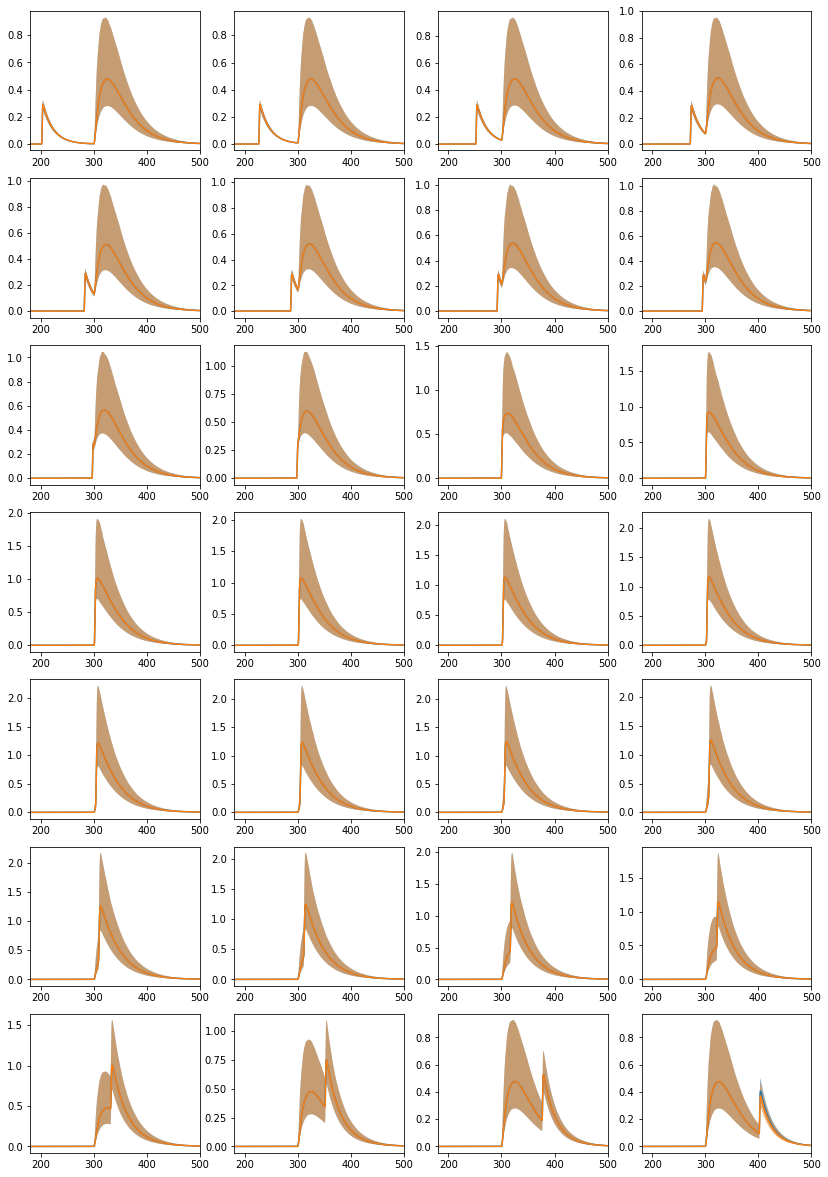

In [26]:
th1s = [0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65]
th2s = [0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]

th1, th2 = 0.5,0.4
fweights = {}
fweightsdel = {}

fcat = {}

tdelI = [-100,-75,-50,-30,-20,-15,-10,-7.5,-5,-3.5,-2,-1,-0.5,0,0.5,1.0,2.0,2.75,3.5,5.0,7.5,10.0,15.0,20.,30.,50,75,100]


tdels = [-100,-75,-50,-30,-20,-15,-10,-7.5,-5,-3.5,-2,-1,-0.5,0,0.5,1.0,2.0,2.75,3.5,5.0,7.5,10.0,15.0,20.,30.,50,75,100]
data = zeros((len(tdels),9))
dcs = zeros((len(tdels),500))
ton = 200
toffset = 100
fig,ax = subplots(nrows=7,ncols=4,figsize=(14,7*3))
for i,td in enumerate(tdels):
    tAPt = td+ton+toffset
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSetwfAP(dis,y,t,tG = 700,ton = ton,toffset = toffset,t_stop = 600, EL = EL0,VDCC = VDCCa,tAP = tAPt)
    dcs[i,:] = Ctracs.max(axis=0)
    data[i,:] = mes.mean(axis=0)
    iy = i//4
    ix = i%4
    ctracso = Ctracs*1.0
    ctracso.sort(axis=1)
    fcat[td] = column_stack((array(trec),ctracso[:,250],ctracso[:,25],ctracso[:,475]))

    ax[iy,ix].plot(array(trec),ctracso[:,250],'C0-')
    #ax[iy,ix].plot(array(trec)-toffset-ton,ctracso[:,25],'C0-')
    ax[iy,ix].fill_between(array(trec),ctracso[:,25],ctracso[:,475],alpha=0.5)
    ax[iy,ix].set_xlim(180,500)
   
    fweights[td] = {(th1,th2) : weightsC(Ctracs,th1,th2) for th1 in th1s for th2 in th2s}

    for td2 in tdelI:
        tG = ton-50.0+td2
        vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSetwfAP(dis,y,t,tG = tG,ton = ton,toffset = toffset,t_stop = 600, EL = EL0,VDCC = VDCCa,tAP = tAPt)
        fweightsdel[(td,td2)] = {(th1,th2) : weightsC(Ctracs,th1,th2) for th1 in th1s for th2 in th2s}

        ctracso = Ctracs*1.0
        ctracso.sort(axis=1)

        fcat[(td,td2)] = column_stack((array(trec),ctracso[:,250],ctracso[:,25],ctracso[:,475]))
    
    ax[iy,ix].plot(array(trec),ctracso[:,250],'C1-')
    #ax[iy,ix].plot(array(trec)-toffset-ton,ctracso[:,25],'C0-')
    ax[iy,ix].fill_between(array(trec),ctracso[:,25],ctracso[:,475],alpha=0.5)
        
    
    with open("STDP_inhibition_temp0b.pickle","wb") as f:
        pickle.dump([fweights,fweightsdel,data,dcs,dis],f)
    
    print(i)

In [25]:
with open("STDP_inhibition_b.pickle","wb") as f:
    pickle.dump([fweights,fweightsdel,data,dcs,dis],f)

In [25]:
dA20 = dis['A2']*1.0 
dis['A2'] = dA20*10

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in sqrt


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


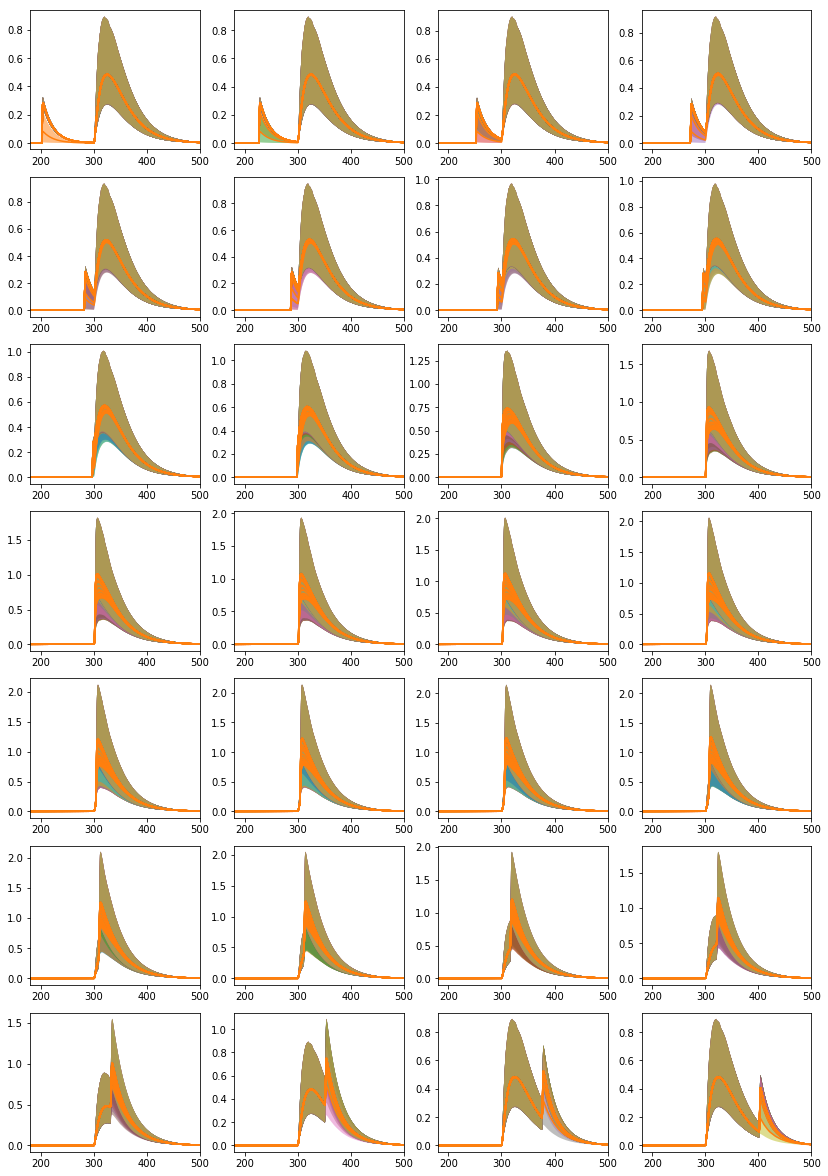

In [26]:
th1s = [0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65]
th2s = [0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]

th1, th2 = 0.5,0.4
fweights = {}
fweightsdel = {}

fcat = {}

tdelI = [-100,-75,-50,-30,-20,-15,-10,-7.5,-5,-3.5,-2,-1,-0.5,0,0.5,1.0,2.0,2.75,3.5,5.0,7.5,10.0,15.0,20.,30.,50,75,100]


tdels = [-100,-75,-50,-30,-20,-15,-10,-7.5,-5,-3.5,-2,-1,-0.5,0,0.5,1.0,2.0,2.75,3.5,5.0,7.5,10.0,15.0,20.,30.,50,75,100]
data = zeros((len(tdels),9))
dcs = zeros((len(tdels),500))
ton = 200
toffset = 100
fig,ax = subplots(nrows=7,ncols=4,figsize=(14,7*3))
for i,td in enumerate(tdels):
    tAPt = td+ton+toffset
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSetwfAP(dis,y,t,tG = 700,ton = ton,toffset = toffset,t_stop = 600, EL = EL0,VDCC = VDCCa,tAP = tAPt)
    dcs[i,:] = Ctracs.max(axis=0)
    data[i,:] = mes.mean(axis=0)
    iy = i//4
    ix = i%4
    ctracso = Ctracs*1.0
    ctracso.sort(axis=1)
    fcat[td] = column_stack((array(trec),ctracso[:,250],ctracso[:,25],ctracso[:,475]))

    ax[iy,ix].plot(array(trec),ctracso[:,250],'C0-')
    #ax[iy,ix].plot(array(trec)-toffset-ton,ctracso[:,25],'C0-')
    ax[iy,ix].fill_between(array(trec),ctracso[:,25],ctracso[:,475],alpha=0.5)
    ax[iy,ix].set_xlim(180,500)
   
    fweights[td] = {(th1,th2) : weightsC(Ctracs,th1,th2) for th1 in th1s for th2 in th2s}

    for td2 in tdelI:
        tG = ton-50.0+td2
        vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSetwfAP(dis,y,t,tG = tG,ton = ton,toffset = toffset,t_stop = 600, EL = EL0,VDCC = VDCCa,tAP = tAPt)
        fweightsdel[(td,td2)] = {(th1,th2) : weightsC(Ctracs,th1,th2) for th1 in th1s for th2 in th2s}

        ctracso = Ctracs*1.0
        ctracso.sort(axis=1)

        ax[iy,ix].plot(array(trec),ctracso[:,250],'C1-')
        #ax[iy,ix].plot(array(trec)-toffset-ton,ctracso[:,25],'C0-')
        ax[iy,ix].fill_between(array(trec),ctracso[:,25],ctracso[:,475],alpha=0.5)
        fcat[(td,td2)] = column_stack((array(trec),ctracso[:,250],ctracso[:,25],ctracso[:,475]))


        with open("STDP_inhibition_temp_exagerado.pickle","wb") as f:
            pickle.dump([fweights,fweightsdel,data,dcs,dis],f)

    print(i)

In [27]:
with open("STDP_inhibition_exagerado.pickle","wb") as f:
    pickle.dump([fweights,fweightsdel,data,dcs,dis],f)

In [32]:
NMDA.tau2

30.0